In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier




In [7]:
#global class for report of model and plot
class model_report:
    def __init__(self,y_test,y_pred,y_proba):
        self.y_test=y_test
        self.y_pred=y_pred
        self.y_proba=y_proba
        self.accuracy=accuracy_score(self.y_test,self.y_pred)
        self.roc_auc_score=roc_auc_score(self.y_test, self.y_proba)
        self.precision=precision_score(self.y_test,self.y_pred)
        self.recall=recall_score(self.y_test,self.y_pred)
        self.f1=f1_score(y_test,y_pred)
        self.confusion_matrix=confusion_matrix(self.y_test,self.y_pred)

    def model_metrics(self):
        print('Accuracy:',self.accuracy)
        print('roc_auc score:',self.roc_auc_score)
        print('precision:',self.precision)
        print('recall :',self.recall)
        print('f1 :',self.f1)
        print('Confusion Matrix:\n',self.confusion_matrix)

    def mod_viz(self):
        #confusion-matrix
        print('confusion matrix:')
        plt.figure(figsize=(8, 6))
        plt.imshow(self.confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.xticks([0, 1], ['Not Responded', 'Responded'])
        plt.yticks([0, 1], ['Not Responded', 'Responded'])
        for i in range(2):
            for j in range(2):
                plt.text(j, i, str(self.confusion_matrix[i, j]), ha='center', va='center')
        plt.show()

        # Generating ROC Curve

        print('roc-curve')
        fpr, tpr, thresholds = roc_curve(self.y_test,self.y_proba)
        roc_auc_curve = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_curve:.2f}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

        # Learning Curve
    def learning_curve(self,model_obj,X_train,y_train,cv):

            train_sizes, train_scores, test_scores=learning_curve(model_obj, X_train, y_train, cv=5)
            train_mean = np.mean(train_scores, axis=1)
            train_std = np.std(train_scores, axis=1)
            test_mean = np.mean(test_scores, axis=1)
            test_std = np.std(test_scores, axis=1)

            plt.figure(figsize=(8, 6))
            plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
            plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
            plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
            plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
            plt.xlabel('Number of Training Examples')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
            
    def feature_importance(self,model):
        for name, score in sorted(zip(x.columns, model.feature_importances_), key=lambda x: x[1],reverse=True):
              print(name, score)
        

# Understanding the dataset-EDA

In [8]:
df=pd.read_csv("C:\\Users\\rohan aryan\\Downloads\\target-marketing-for-canadian-bank-fall2023\\train_classif.csv")
df

,Customer_id,Target,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,...,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
0,CTSP000001,0,43824.59,0,0,0,0,0,0,0,...,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
1,CTSP000002,1,11256.21,0,0,0,0,0,0,0,...,3,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
2,CTSP000003,1,18795.11,0,1,1,0,0,0,0,...,0,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375
3,CTSP000004,0,22274.72,0,0,0,0,0,0,0,...,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
4,CTSP000005,0,47923.40,0,1,0,0,0,0,0,...,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63994,CTSP063995,0,40444.92,0,0,1,0,1,0,0,...,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
63995,CTSP063996,0,47395.91,0,0,0,0,0,0,0,...,1,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
63996,CTSP063997,1,10086.31,0,0,1,0,0,0,0,...,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
63997,CTSP063998,0,26452.64,0,0,0,0,0,0,0,...,3,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125


In [9]:
#statistical information of the dataframe
df.describe()

,Target,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,Transaction1,...,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
count,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,...,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000,63999.000000
mean,0.499773,22697.014218,0.001484,0.200441,0.160456,0.001766,0.092158,0.022125,0.041876,312.852441,...,0.595291,1.379736,1.836435,1.391770,1.757322,1.882755,1.678434,1.412233,1.678434,1.315226
std,0.500004,10819.489043,0.039303,0.400333,0.367031,0.041983,0.289251,0.147092,0.200307,4932.061568,...,1.162643,0.206340,0.370122,0.161833,0.357483,0.516006,0.160600,0.575083,0.160600,0.106634
min,0.000000,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.025000,1.425000,1.125000,1.425000,1.175000,1.425000,0.525000,1.425000,1.125000
25%,0.000000,13499.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.425000,1.575000,1.425000,1.575000,1.575000,1.675000,0.525000,1.675000,1.375000
50%,0.000000,19982.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.425000,1.925000,1.425000,1.675000,2.375000,1.675000,1.575000,1.675000,1.375000
75%,1.000000,30104.035000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.575000,2.375000,1.575000,1.675000,2.375000,1.875000,1.575000,1.875000,1.375000
max,1.000000,50000.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,505000.000000,...,56.000000,1.575000,2.375000,1.575000,2.375000,2.375000,1.875000,2.125000,1.875000,1.375000


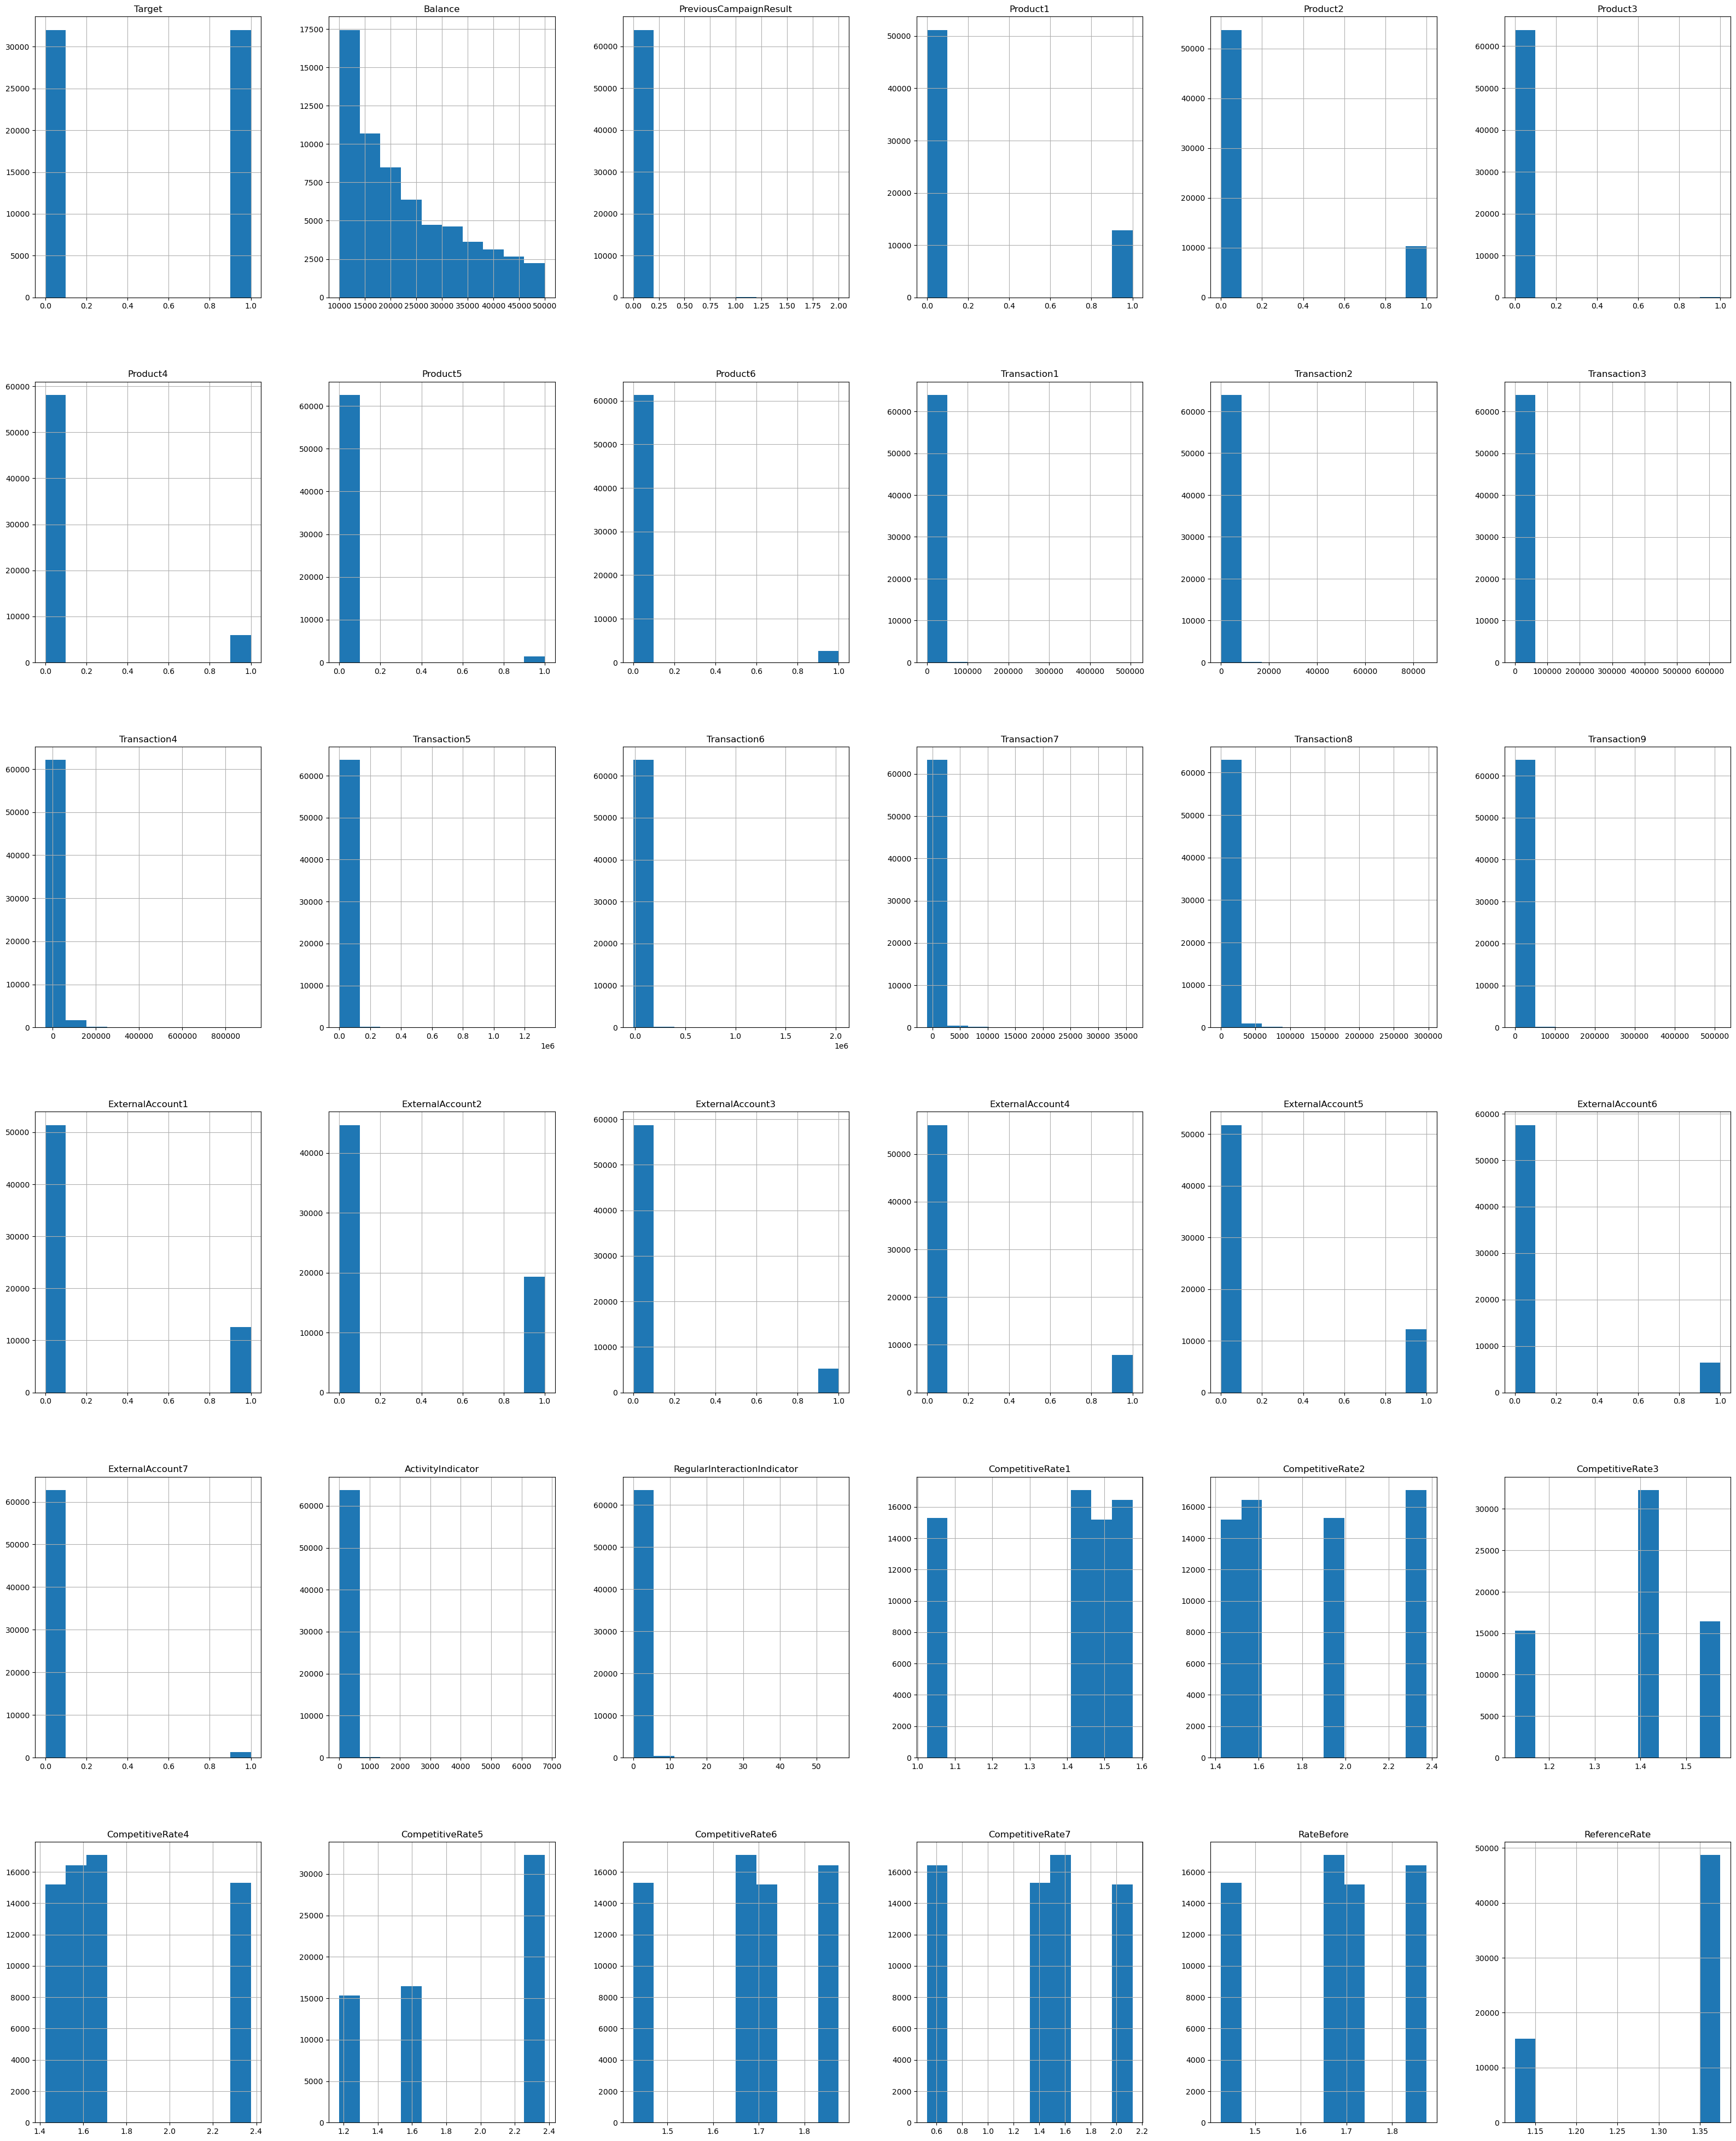

In [10]:
#distribution of dataframe
df.hist(figsize=(40,50))
plt.show()

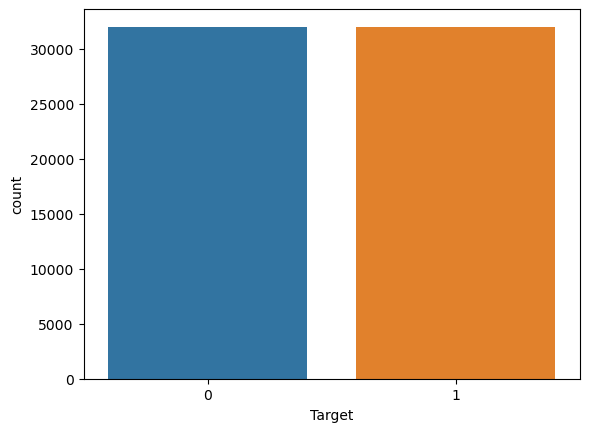

In [11]:
#checking if target is biased
sns.countplot(x='Target',data=df)
plt.show()

In [12]:
#dimensions of the dataframe
df.shape

(63999, 37)

In [13]:
#used to display all the columns in the dataframe
print(pd.get_option("display.max_columns")) #--> since we have more columns than the usual we configured the set option to allow all the columns
pd.set_option('display.max_columns', None)

20


In [14]:
#first 25 records of the dataframe
df.head(25)

,Customer_id,Target,Balance,PreviousCampaignResult,Product1,Product2,Product3,Product4,Product5,Product6,Transaction1,Transaction2,Transaction3,Transaction4,Transaction5,Transaction6,Transaction7,Transaction8,Transaction9,ExternalAccount1,ExternalAccount2,ExternalAccount3,ExternalAccount4,ExternalAccount5,ExternalAccount6,ExternalAccount7,ActivityIndicator,RegularInteractionIndicator,CompetitiveRate1,CompetitiveRate2,CompetitiveRate3,CompetitiveRate4,CompetitiveRate5,CompetitiveRate6,CompetitiveRate7,RateBefore,ReferenceRate
0,CTSP000001,0,43824.59,0,0,0,0,0,0,0,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0,0,0,0,0,0,0,0,0,1.025,1.925,1.125,2.375,1.175,1.425,1.475,1.425,1.125
1,CTSP000002,1,11256.21,0,0,0,0,0,0,0,0.00,0.0,0.00,8525.00,0.00,0.00,0.00,0.0,0.00,0,0,0,0,0,1,0,11,3,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
2,CTSP000003,1,18795.11,0,1,1,0,0,0,0,13422.35,800.0,0.00,0.00,0.00,13123.28,0.00,0.0,0.00,0,0,0,0,0,0,0,6,0,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375
3,CTSP000004,0,22274.72,0,0,0,0,0,0,0,0.00,0.0,0.00,1000.00,23900.00,0.00,0.00,0.0,0.00,0,0,0,0,0,1,0,14,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
4,CTSP000005,0,47923.40,0,1,0,0,0,0,0,0.00,0.0,0.00,0.00,2000.00,27629.11,0.00,0.0,0.00,0,1,0,0,0,0,0,2,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
5,CTSP000006,1,10013.83,0,0,0,0,0,0,0,0.00,0.0,0.00,30000.00,42080.17,0.00,0.00,0.0,0.00,0,1,0,0,1,0,0,12,0,1.475,1.425,1.425,1.425,2.375,1.725,2.125,1.725,1.375
6,CTSP000007,1,24092.37,0,0,0,0,0,0,0,0.00,0.0,0.00,10000.00,0.00,0.00,0.00,0.0,0.00,0,0,0,1,0,0,0,0,0,1.425,2.375,1.425,1.675,2.375,1.675,1.575,1.675,1.375
7,CTSP000008,1,10777.00,0,1,0,0,0,0,0,0.00,0.0,0.00,33227.00,0.00,0.00,0.00,0.0,0.00,0,0,0,0,1,0,0,2,0,1.575,1.575,1.575,1.575,1.575,1.875,0.525,1.875,1.375
8,CTSP000009,1,28528.26,0,0,0,0,0,0,0,0.00,0.0,0.00,31501.00,500.00,0.00,0.00,0.0,0.00,0,1,0,0,0,0,0,0,1,1.575,1.575,1.575,1.575,1.575,1.875,0.525,1.875,1.375
9,CTSP000010,1,37049.83,0,0,0,0,0,0,0,0.00,0.0,0.00,0.00,6000.00,0.00,0.00,0.0,0.00,0,0,0,0,1,0,0,0,0,1.575,1.575,1.575,1.575,1.575,1.875,0.525,1.875,1.375


In [15]:
#information about the dataframe, checking for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63999 entries, 0 to 63998
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer_id                  63999 non-null  object 
 1   Target                       63999 non-null  int64  
 2   Balance                      63999 non-null  float64
 3   PreviousCampaignResult       63999 non-null  int64  
 4   Product1                     63999 non-null  int64  
 5   Product2                     63999 non-null  int64  
 6   Product3                     63999 non-null  int64  
 7   Product4                     63999 non-null  int64  
 8   Product5                     63999 non-null  int64  
 9   Product6                     63999 non-null  int64  
 10  Transaction1                 63999 non-null  float64
 11  Transaction2                 63999 non-null  float64
 12  Transaction3                 63999 non-null  float64
 13  Transaction4    

In [16]:
#dividing features WRT categorical and numerical

#dependent feature, target feature
Target="Target"
#independent features, predictors
predictor_columns=[col for col in df.columns if col not in [Target]]
predictor_columns.remove('Customer_id')


#categorical features
categorical_features=['Product1', 'Product2', 'Product3', 'Product4', 'Product5', 'Product6','PreviousCampaignResult','ExternalAccount1', 'ExternalAccount2',
       'ExternalAccount3', 'ExternalAccount4', 'ExternalAccount5',
       'ExternalAccount6', 'ExternalAccount7']

#numeric features
numerical_features=[col for col in predictor_columns if col not in categorical_features]


print(f"TARGET: {Target}")
print('='*90)
print(f"Predictors(target excluded,Customer_id removed): {predictor_columns}")
print('length:',len(predictor_columns))
print('='*90)
print(f"Categorical Columns: {categorical_features}")
print('length:',len(categorical_features))
print('='*90)
print(f"Numerical Columns: {numerical_features}")
print('length:',len(numerical_features))
print('='*90)
print('Removed_Column = Customer_id')

TARGET: Target
Predictors(target excluded,Customer_id removed): ['Balance', 'PreviousCampaignResult', 'Product1', 'Product2', 'Product3', 'Product4', 'Product5', 'Product6', 'Transaction1', 'Transaction2', 'Transaction3', 'Transaction4', 'Transaction5', 'Transaction6', 'Transaction7', 'Transaction8', 'Transaction9', 'ExternalAccount1', 'ExternalAccount2', 'ExternalAccount3', 'ExternalAccount4', 'ExternalAccount5', 'ExternalAccount6', 'ExternalAccount7', 'ActivityIndicator', 'RegularInteractionIndicator', 'CompetitiveRate1', 'CompetitiveRate2', 'CompetitiveRate3', 'CompetitiveRate4', 'CompetitiveRate5', 'CompetitiveRate6', 'CompetitiveRate7', 'RateBefore', 'ReferenceRate']
length: 35
Categorical Columns: ['Product1', 'Product2', 'Product3', 'Product4', 'Product5', 'Product6', 'PreviousCampaignResult', 'ExternalAccount1', 'ExternalAccount2', 'ExternalAccount3', 'ExternalAccount4', 'ExternalAccount5', 'ExternalAccount6', 'ExternalAccount7']
length: 14
Numerical Columns: ['Balance', 'Trans

In [17]:
#pipelining
#for categorical variables, do onehotencoding
#for numerical variables, do standard scaling-Standardization
#use a column transformer to merge the two pipelines

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder ,StandardScaler


#convert the categorical and numeric dataframes into lists first
categorical_list=list(categorical_features)
numerical_list=list(numerical_features)
#Pipelines:

categorical_pipe=Pipeline([
    ("onehot",OneHotEncoder())
])

numeric_pipe= Pipeline([
  ('scaler', StandardScaler()),
])

full_pipe = ColumnTransformer([
  ("categorical", categorical_pipe, categorical_list),
  ("numerical", numeric_pipe, numerical_list),
])

# Splitting of Data: Using "train_test_split"

In [18]:
#train test split
#note-X_train, X_test, y_train, y_test will be used throughtout the rest of the code without any change in variable names
x= df[predictor_columns]
y=df[Target]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.22, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(49919, 35)
(14080, 35)
(49919,)
(14080,)


# Pre-processing: Using Pipelines

In [19]:
#note-X_train and X_test can be considered parent variables which will be used for each model (without any change in variable names)
X_train = full_pipe.fit_transform(X_train)
X_test = full_pipe.fit_transform(X_test)
print(f"X_train transformed.shape: {X_train.shape}")
print(f"X_test transformed.shape: {X_test.shape}")

X_train transformed.shape: (49919, 50)
X_test transformed.shape: (14080, 50)


In [20]:
# Print the feature names after one-hot encoding
categorical_feature_names = full_pipe.named_transformers_['categorical']['onehot'].get_feature_names_out()
print(f'Categorical Feature Names: {categorical_feature_names}')

# Print the original numerical feature names
numerical_feature_names = numerical_features  # Assuming numerical_features is a list of original numerical feature names
print(f'Numerical Feature Names: {numerical_feature_names}')


Categorical Feature Names: ['Product1_0' 'Product1_1' 'Product2_0' 'Product2_1' 'Product3_0'
 'Product3_1' 'Product4_0' 'Product4_1' 'Product5_0' 'Product5_1'
 'Product6_0' 'Product6_1' 'PreviousCampaignResult_0'
 'PreviousCampaignResult_1' 'PreviousCampaignResult_2'
 'ExternalAccount1_0' 'ExternalAccount1_1' 'ExternalAccount2_0'
 'ExternalAccount2_1' 'ExternalAccount3_0' 'ExternalAccount3_1'
 'ExternalAccount4_0' 'ExternalAccount4_1' 'ExternalAccount5_0'
 'ExternalAccount5_1' 'ExternalAccount6_0' 'ExternalAccount6_1'
 'ExternalAccount7_0' 'ExternalAccount7_1']
Numerical Feature Names: ['Balance', 'Transaction1', 'Transaction2', 'Transaction3', 'Transaction4', 'Transaction5', 'Transaction6', 'Transaction7', 'Transaction8', 'Transaction9', 'ActivityIndicator', 'RegularInteractionIndicator', 'CompetitiveRate1', 'CompetitiveRate2', 'CompetitiveRate3', 'CompetitiveRate4', 'CompetitiveRate5', 'CompetitiveRate6', 'CompetitiveRate7', 'RateBefore', 'ReferenceRate']


In [21]:
#importing 'test.csv' to use in the models (exporting for kaggle)
test_data=pd.read_csv("data\\test.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'data\\test.csv'

# Model Building:

# Model-1: Logistic Regression

In [22]:
#class instance initialization
log_reg=LogisticRegression()

In [23]:
#parameters for hyper-parameter tuning
#param_grid_log_reg = {
#    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#    'classifier__penalty': ['l2']
#}

param_grid_log_reg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2']
}

In [24]:
#using grid search cv to get the best estimator, parameters
grid_search = GridSearchCV(log_reg, param_grid_log_reg, cv=5, scoring='accuracy', error_score='raise')

In [25]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise', estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2']},
             scoring='accuracy')

In [26]:
print("Best Parameters for Logistic Regression:")
print(grid_search.best_params_)
# Using the best model obtained from GridSearchCV ensures that the model has the optimal hyperparameters.
logreg_model = grid_search.best_estimator_

# Training the model
logreg_model.fit(X_train, y_train)


Best Parameters for Logistic Regression:
{'C': 0.001, 'penalty': 'l2'}


LogisticRegression(C=0.001)

In [27]:
# Predicting on the test set
y_pred_LR = logreg_model.predict(X_test)
y_proba_LR = logreg_model.predict_proba(X_test)[:, 1]


In [28]:
#using the class for metrics and plots
log_model_report=model_report(y_test,y_pred_LR,y_proba_LR)

In [29]:
#displaying the metrics
log_model_report.model_metrics()

Accuracy: 0.6143465909090909
roc_auc score: 0.6484514389378662
precision: 0.6373269526576654
recall : 0.5299133153332386
f1 : 0.5786778398510243
Confusion Matrix:
 [[4921 2122]
 [3308 3729]]


confusion matrix:


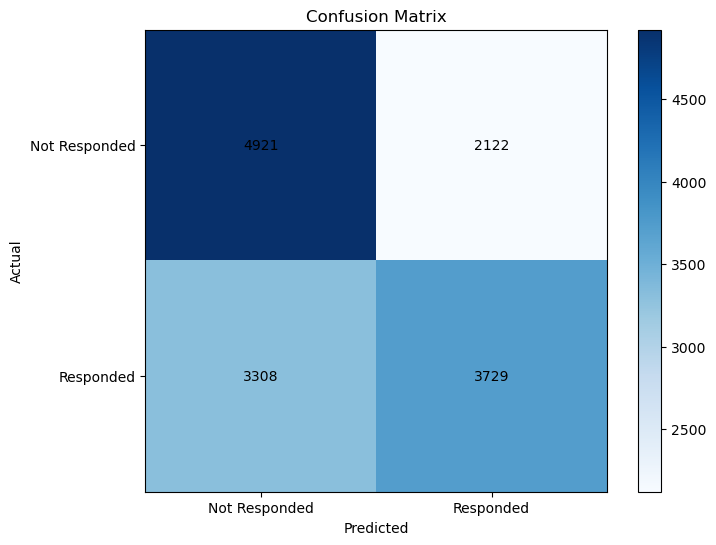

roc-curve


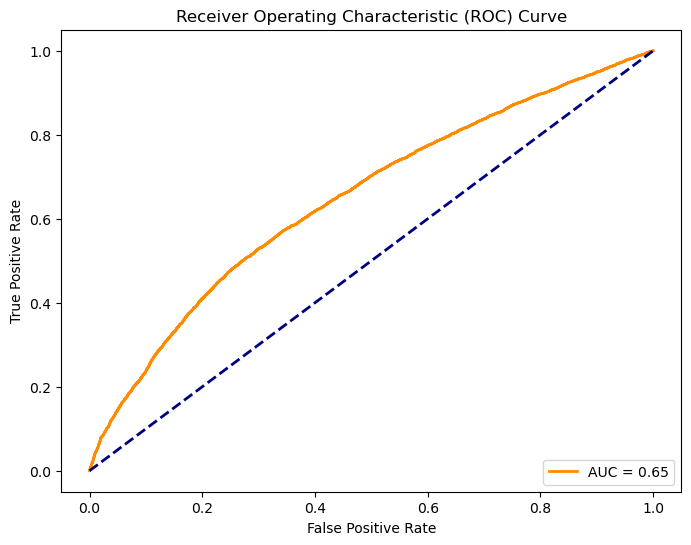

In [30]:
#plots for roc-auc and confusion matrix
log_model_report.mod_viz()

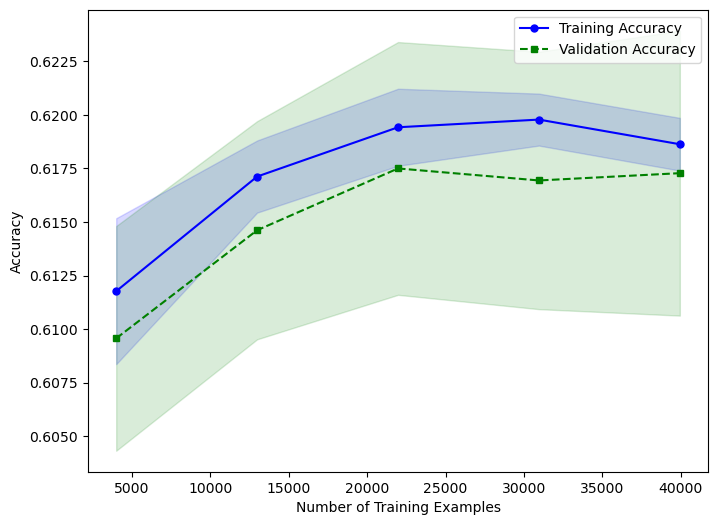

In [31]:
log_model_report.learning_curve(logreg_model,X_train,y_train,5)

## Kaggle score: 0.634

# Feature Importance

logistic regression does not support 'feature_importances_',we went with the approach to use the coefficients as a measure of feature importance. Positive coefficients indicate a positive effect on the predicted class, and negative coefficients indicate a negative effect

In [32]:
print("Logistic Regression Coefficients:")
for feature, coefficient in zip(x.columns, logreg_model.coef_[0]):
    print(f"{feature}: {coefficient}")

Logistic Regression Coefficients:
Balance: 0.09021073210666383
PreviousCampaignResult: -0.09019620715123372
Product1: -0.10679930669596605
Product2: 0.10681383165139621
Product3: -0.0023458894657145224
Product4: 0.0023604144211445644
Product5: -0.022707816086848367
Product6: 0.022722341042278372
Transaction1: -0.02875053630596632
Transaction2: 0.028765061261396305
Transaction3: -0.021232348552190115
Transaction4: 0.021246873507620084
Transaction5: 0.009734644338356512
Transaction6: -0.009895344468556184
Transaction7: 0.00017522508562973187
Transaction8: -0.012771227359146582
Transaction9: 0.012785752314576532
ExternalAccount1: -0.027674810451972016
ExternalAccount2: 0.02768933540740202
ExternalAccount3: 0.018422806949780834
ExternalAccount4: -0.0184082819943507
ExternalAccount5: -0.019578518719273796
ExternalAccount6: 0.019593043674703797
ExternalAccount7: -0.04487747366214191
ActivityIndicator: 0.044891998617571996
RegularInteractionIndicator: -0.012085667728084202
CompetitiveRate1: 0

# Model-2: Random Forest Classifier

In [33]:
random_forest_Classifier = RandomForestClassifier()
random_forest_Classifier.fit(X_train,y_train)

RandomForestClassifier()

In [34]:
y_pred_RF=random_forest_Classifier.predict(X_test)
y_proba_RF=random_forest_Classifier.predict_proba(X_test)[:,1]

In [35]:
RF_report=model_report(y_test,y_pred_RF,y_proba_RF)

In [36]:
RF_report.model_metrics()

Accuracy: 0.5926136363636364
roc_auc score: 0.6289964238637942
precision: 0.5842289265829341
recall : 0.6411823220122211
f1 : 0.6113821138211382
Confusion Matrix:
 [[3832 3211]
 [2525 4512]]


confusion matrix:


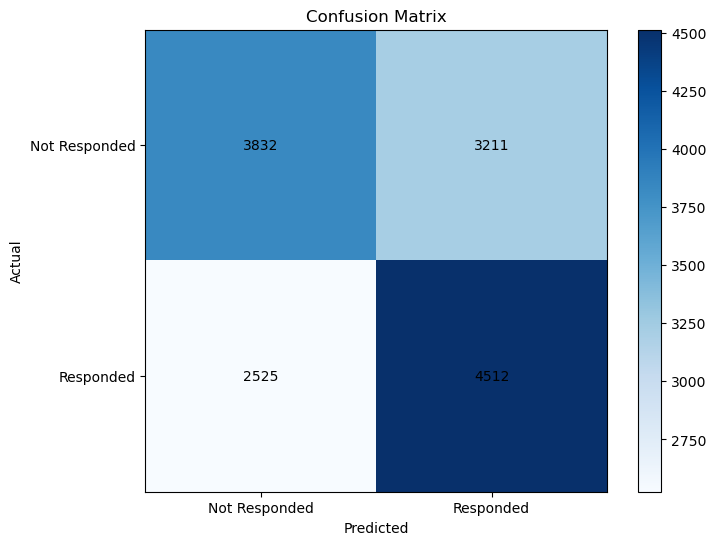

roc-curve


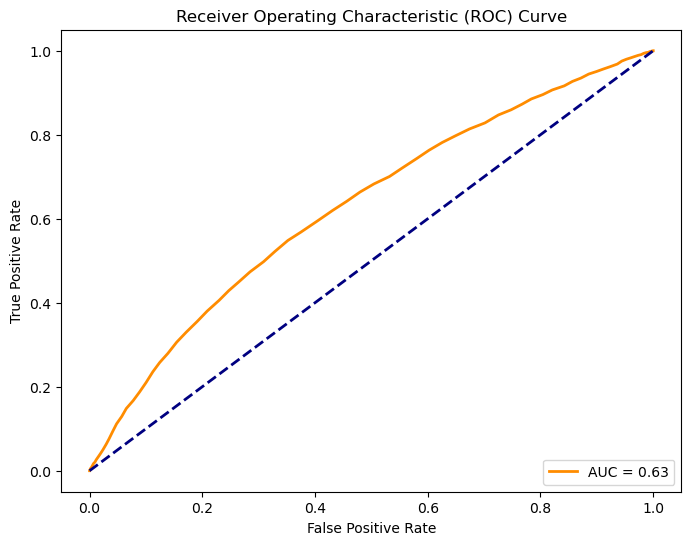

In [37]:
RF_report.mod_viz()

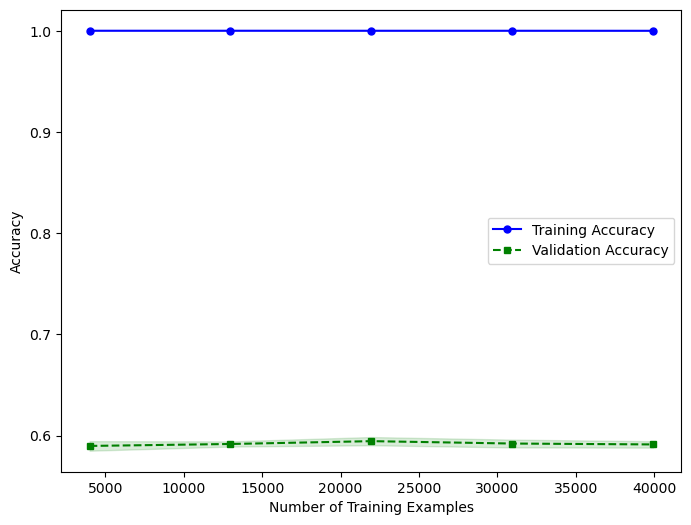

In [38]:
RF_report.learning_curve(random_forest_Classifier,X_train,y_train,5)

In [39]:
#create a precision - recall curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train,y_proba_RF)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.xticks([0, 0.2, 0.4, .5,.53,0.6, 0.8, 1.0])
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(10, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

plt.show()

#plot the precision and recall curve

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])


plot_precision_vs_recall(precisions, recalls)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [49919, 14080]

In [ ]:
Recall_Threshhold = (y_forest_scores >.53)
print(precision_score(y_train,Recall_Threshhold))
print(recall_score(y_train,Recall_Threshhold))
Recall_Threshhold

In [ ]:
from sklearn.model_selection import cross_val_score

Average_Score = cross_val_score(random_forest_Classifier,X_train_transformed, Recall_Threshhold, cv = 4, scoring = "accuracy")

print(Average_Score) # [ 0.72333333  0.727       0.7195      0.71966667]

print(np.average(Average_Score))

In [ ]:
NewR_Threshhold = Recall_Threshhold.astype(int)

#Now run Grid Search on the RandomForest and use the new threshhold
from sklearn.model_selection import GridSearchCV
n_estimators = [3, 4, 6, 7, 10, 20, 50, 100]
param_grid = {'n_estimators' : n_estimators}

#tune the random forest classifier with the hyper parameters

Random_Forest_Classifier = RandomForestClassifier()
grid_search = GridSearchCV(Random_Forest_Classifier,param_grid,cv=4,refit = True,scoring='roc_auc', n_jobs = -1, verbose=0)
grid_search.fit(X_train_transformed, NewR_Threshhold)


In [ ]:
#get the best parameters and estimators
forest_best_param_ = grid_search.best_params_
forest_best_estimators_ = grid_search.best_estimator_

print(forest_best_param_)
print(forest_best_estimators_)

y_pred = forest_best_estimators_.predict(X_test)

In [ ]:
print(len(y_pred))

In [ ]:
result_df_test = pd.DataFrame({'Customer_id': test_data['Customer_id'],'Target': y_pred})
result_df_test.to_csv('predictions_test_new_27.csv', index=False)
print(result_df_test)

# Feature Importance:

In [40]:
RF_report.feature_importance(random_forest_Classifier)

CompetitiveRate4 0.28641088438416334
RateBefore 0.17467904142346363
ReferenceRate 0.05970683745470274
ExternalAccount1 0.011042002566556044
ExternalAccount2 0.010985509923146732
Transaction9 0.009766774001422056
Transaction8 0.009766342185250219
ExternalAccount7 0.00851899872705459
ActivityIndicator 0.008427147019651401
ExternalAccount6 0.008322694980212214
ExternalAccount5 0.008264328556478542
CompetitiveRate7 0.008227845409271019
Product5 0.007412933722912256
Product6 0.007178318999538076
ExternalAccount4 0.007056095233998915
CompetitiveRate6 0.006887995708219199
ExternalAccount3 0.006877650446245862
CompetitiveRate1 0.006745738933221632
RegularInteractionIndicator 0.006709598702267865
Product1 0.00553259967260315
PreviousCampaignResult 0.005241047888062028
Balance 0.005199764758548586
Transaction4 0.005025826673813876
Product2 0.004993970050776007
Transaction3 0.004963915940180361
CompetitiveRate5 0.003453640251995309
Transaction1 0.0028231556694736076
Transaction2 0.002813716879879

# Kaggle Score: 0.61

# Model-4: XGB

In [41]:
import xgboost as xgb
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

In [42]:
parameters_xgb = {
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200)
}

In [43]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=parameters_xgb, n_iter=10, cv=4, scoring='accuracy', n_jobs = -1)

In [44]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002B0059FA

In [45]:
# Get the best parameters and estimator from the search
best_params = random_search.best_params_
best_estimator_xgb = random_search.best_estimator_

print("Best Parameters for XGBoost:")
print(best_params)

Best Parameters for XGBoost:
{'learning_rate': 0.08313649423257866, 'max_depth': 5, 'n_estimators': 74, 'subsample': 0.5630437241231167}


In [46]:
# Training the best model on the entire training set
best_estimator_xgb.fit(X_train, y_train)

# Making predictions on the test set
y_pred_xgb = best_estimator_xgb.predict(X_test)
y_proba_xgb = best_estimator_xgb.predict_proba(X_test)[:, 1]

In [47]:
xgb_report=model_report(y_test,y_pred_xgb,y_proba_xgb)

In [48]:
xgb_report.model_metrics()

Accuracy: 0.6233664772727273
roc_auc score: 0.6662831505953875
precision: 0.6300630063006301
recall : 0.5968452465539292
f1 : 0.6130044515799459
Confusion Matrix:
 [[4577 2466]
 [2837 4200]]


confusion matrix:


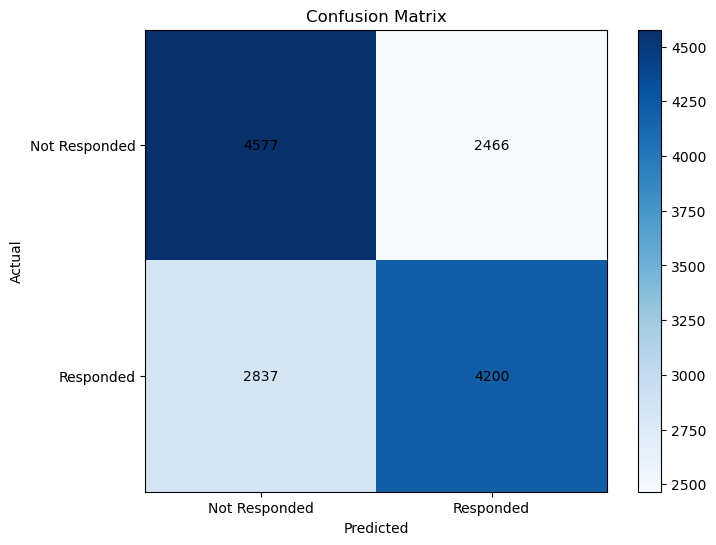

roc-curve


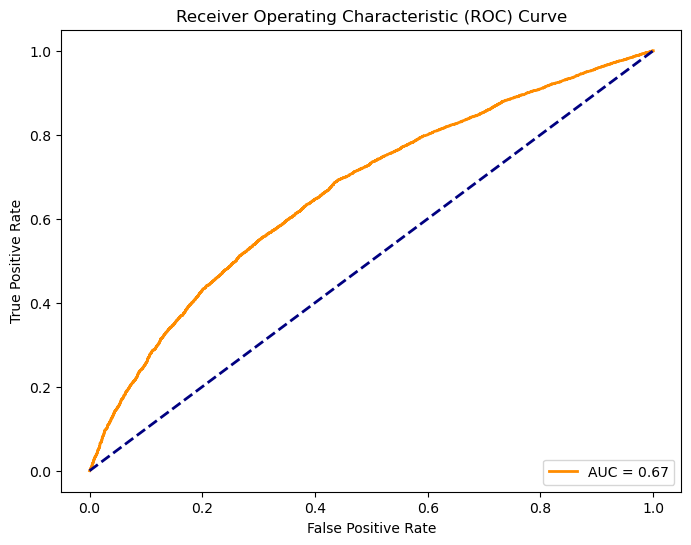

In [49]:
xgb_report.mod_viz()

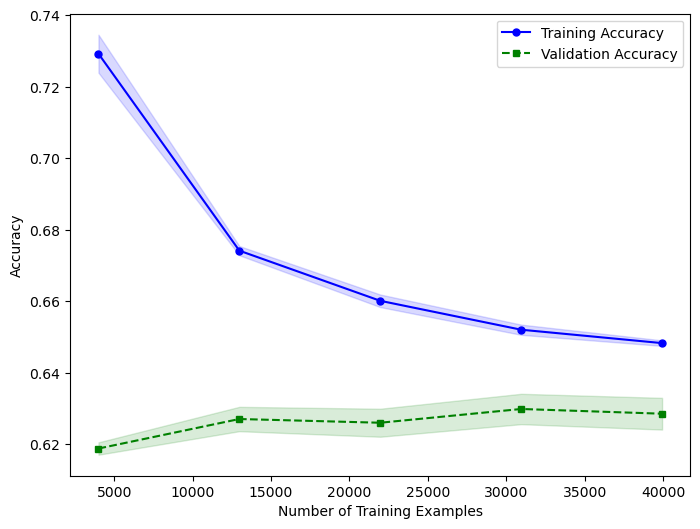

In [50]:
xgb_report.learning_curve(best_estimator_xgb,X_train,y_train,5)

# Feature Importance

In [51]:
xgb_report.feature_importance(best_estimator_xgb)

RateBefore 0.15198956
CompetitiveRate4 0.053712197
Balance 0.04206999
ReferenceRate 0.039119564
Transaction1 0.03407529
CompetitiveRate2 0.031176412
Transaction5 0.030728418
ExternalAccount7 0.026225239
Transaction6 0.024629928
RegularInteractionIndicator 0.024463762
CompetitiveRate5 0.024399465
Product1 0.023406368
ExternalAccount3 0.023002082
Product3 0.022981897
CompetitiveRate7 0.0229303
CompetitiveRate6 0.02292128
Product5 0.021959327
ExternalAccount5 0.020939296
Transaction3 0.020592872
ExternalAccount1 0.020234583
Transaction8 0.018094841
PreviousCampaignResult 0.0
Product2 0.0
Product4 0.0
Product6 0.0
Transaction2 0.0
Transaction4 0.0
Transaction7 0.0
Transaction9 0.0
ExternalAccount2 0.0
ExternalAccount4 0.0
ExternalAccount6 0.0
ActivityIndicator 0.0
CompetitiveRate1 0.0
CompetitiveRate3 0.0


# Kaggle Score: 0.65

# Model-5: LightGBM

In [52]:
lgb_classifier= lgb.LGBMClassifier(random_state=42)

In [53]:
lgb_classifier.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 24948, number of negative: 24971
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 49919, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499770 -> initscore=-0.000921
[LightGBM] [Info] Start training from score -0.000921


LGBMClassifier(random_state=42)

In [54]:
# Making predictions on the test set
y_pred_lgb = best_estimator_xgb.predict(X_test)
y_proba_lgb = best_estimator_xgb.predict_proba(X_test)[:, 1]

In [55]:
#report
lgb_report=model_report(y_test,y_pred_lgb,y_proba_lgb)

In [56]:
lgb_report.model_metrics()

Accuracy: 0.6233664772727273
roc_auc score: 0.6662831505953875
precision: 0.6300630063006301
recall : 0.5968452465539292
f1 : 0.6130044515799459
Confusion Matrix:
 [[4577 2466]
 [2837 4200]]


confusion matrix:


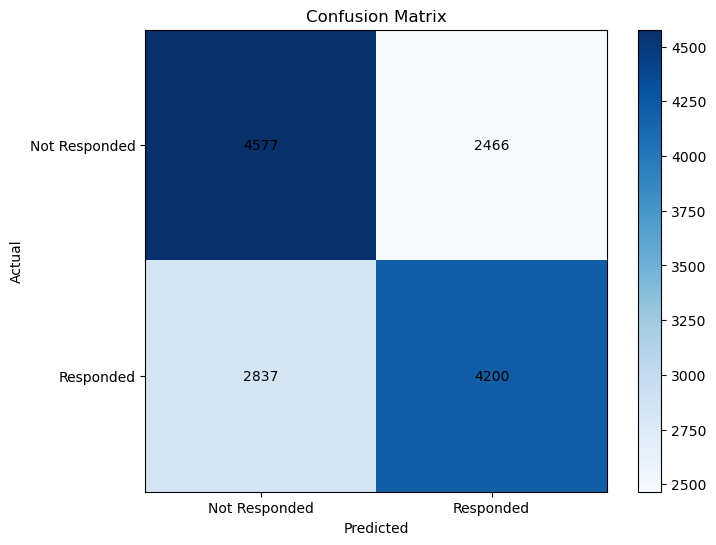

roc-curve


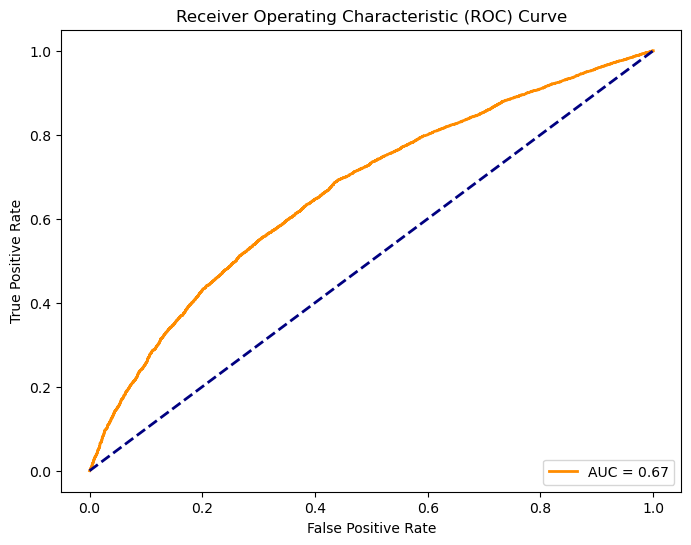

In [57]:
lgb_report.mod_viz()

[LightGBM] [Info] Number of positive: 2029, number of negative: 1964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1692
[LightGBM] [Info] Number of data points in the train set: 3993, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508139 -> initscore=0.032560
[LightGBM] [Info] Start training from score 0.032560
[LightGBM] [Info] Number of positive: 6479, number of negative: 6499
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2666
[LightGBM] [Info] Number of data points in the train set: 12978, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499229 -> initscore=-0.003082
[LightGBM

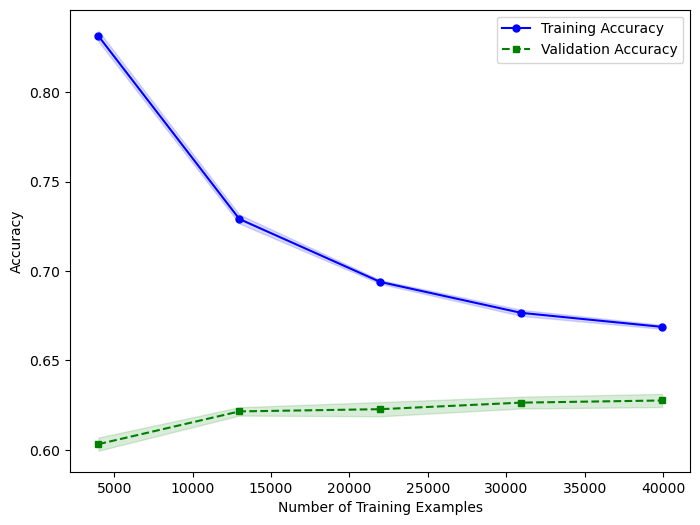

In [58]:
lgb_report.learning_curve(lgb_classifier,X_train,y_train,5)

# Feature Importance

In [59]:
lgb_report.feature_importance(best_estimator_xgb)

RateBefore 0.15198956
CompetitiveRate4 0.053712197
Balance 0.04206999
ReferenceRate 0.039119564
Transaction1 0.03407529
CompetitiveRate2 0.031176412
Transaction5 0.030728418
ExternalAccount7 0.026225239
Transaction6 0.024629928
RegularInteractionIndicator 0.024463762
CompetitiveRate5 0.024399465
Product1 0.023406368
ExternalAccount3 0.023002082
Product3 0.022981897
CompetitiveRate7 0.0229303
CompetitiveRate6 0.02292128
Product5 0.021959327
ExternalAccount5 0.020939296
Transaction3 0.020592872
ExternalAccount1 0.020234583
Transaction8 0.018094841
PreviousCampaignResult 0.0
Product2 0.0
Product4 0.0
Product6 0.0
Transaction2 0.0
Transaction4 0.0
Transaction7 0.0
Transaction9 0.0
ExternalAccount2 0.0
ExternalAccount4 0.0
ExternalAccount6 0.0
ActivityIndicator 0.0
CompetitiveRate1 0.0
CompetitiveRate3 0.0


# Kaggle Score: 0.64

# Model-6:Decision Tree Classifier

In [60]:
decision_tree_classifier =DecisionTreeClassifier(random_state=42)
decision_tree_classifier.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [61]:
y_pred_dtc = decision_tree_classifier.predict(X_test)

In [ ]:
#y_proba_dtc=decision_tree_classifier.predict_proba(X_test)

In [62]:
#model report
conf_matrix = confusion_matrix(y_test, y_pred_dtc)
roc_auc = roc_auc_score(y_test, y_pred_dtc)
precision = precision_score(y_test, y_pred_dtc)
recall = recall_score(y_test,y_pred_dtc)
f1 = f1_score(y_test, y_pred_dtc)
accuracy = accuracy_score(y_test, y_pred_dtc)

# Printing Evaluation Metrics
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

ROC-AUC Score: 0.5379
Precision: 0.5358
Recall: 0.5630
F1 Score: 0.5491
Accuracy: 0.5379


# Feature Importance

In [63]:
lgb_report.feature_importance(decision_tree_classifier)

CompetitiveRate4 0.30200833644035735
RateBefore 0.17356900790579646
ReferenceRate 0.05565100233384965
ExternalAccount2 0.011863190375471453
ExternalAccount1 0.011785114013704133
ExternalAccount7 0.010307421629684902
ActivityIndicator 0.009473697589998489
Transaction9 0.009346854929638467
Transaction8 0.009240295227562492
ExternalAccount5 0.009198902911485212
ExternalAccount6 0.009022935081684743
CompetitiveRate7 0.007857659289231914
CompetitiveRate1 0.007694664304158563
Balance 0.007248535521330825
RegularInteractionIndicator 0.0072152390117814595
ExternalAccount4 0.007149836241986834
ExternalAccount3 0.006788040028405931
Product6 0.006629802971280994
PreviousCampaignResult 0.006370776712929713
CompetitiveRate6 0.006160132379230355
Product5 0.005985989517468108
Product2 0.00549426649718831
Transaction3 0.005022945851052277
Product1 0.004755087214776806
Transaction4 0.004124970576020401
CompetitiveRate5 0.0035926517551209754
CompetitiveRate3 0.002877183792446876
Transaction2 0.002405989

# Kaggle Score: 0.56

# Model-3:KNearestNeighbours

In [64]:
knn_classifier=KNeighborsClassifier()

In [65]:
parameters_Knn = {
    'n_neighbors': [700,1000,1500],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [66]:
#using GridSearchcv for hyperparameter tuning
grid_search_knn=GridSearchCV(knn_classifier,parameters_Knn,cv=4,scoring='roc_auc')

In [67]:
grid_search_knn.fit(X_train,y_train)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [700, 1000, 1500],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [68]:
# Displaying the best parameters helps in understanding the configuration that resulted in the best model performance.
print("Best Parameters for KNN:")
print(grid_search_knn.best_params_)

Best Parameters for KNN:
{'metric': 'euclidean', 'n_neighbors': 1500, 'weights': 'uniform'}


In [69]:
# Using the best model obtained from GridSearchCV ensures that the model has the optimal hyperparameters.
best_knn_classifier = grid_search_knn.best_estimator_

In [70]:
# Training the model
best_knn_classifier.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=1500)

In [71]:
#making predictions using the best estimator from grid search cv
y_pred_knn = best_knn_classifier.predict(X_test)
y_proba_knn = best_knn_classifier.predict_proba(X_test)[:, 1]#Probabilities for positive class

C:\Users\rohan aryan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [72]:
#calling the class for model report generation
knn_model_report=model_report(y_test,y_pred_knn,y_proba_knn)

In [73]:
#model metrics
knn_model_report.model_metrics()

Accuracy: 0.5754261363636364
roc_auc score: 0.632323940125328
precision: 0.6812735364601163
recall : 0.28279096205769505
f1 : 0.3996786503313918
Confusion Matrix:
 [[6112  931]
 [5047 1990]]


confusion matrix:


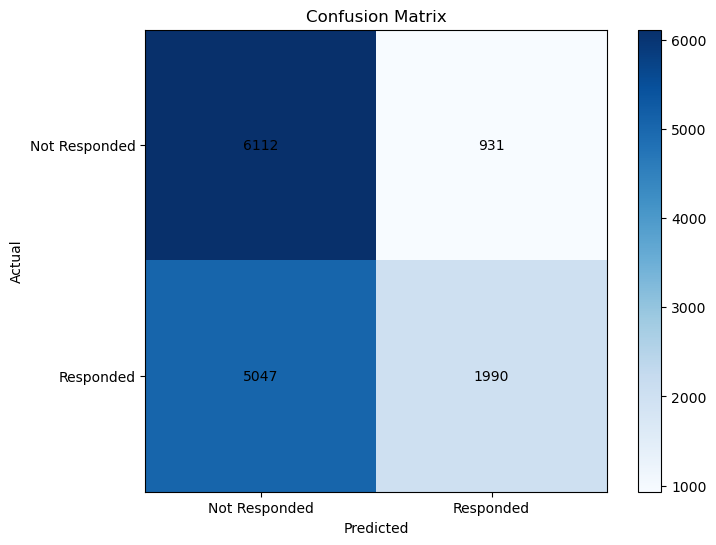

roc-curve


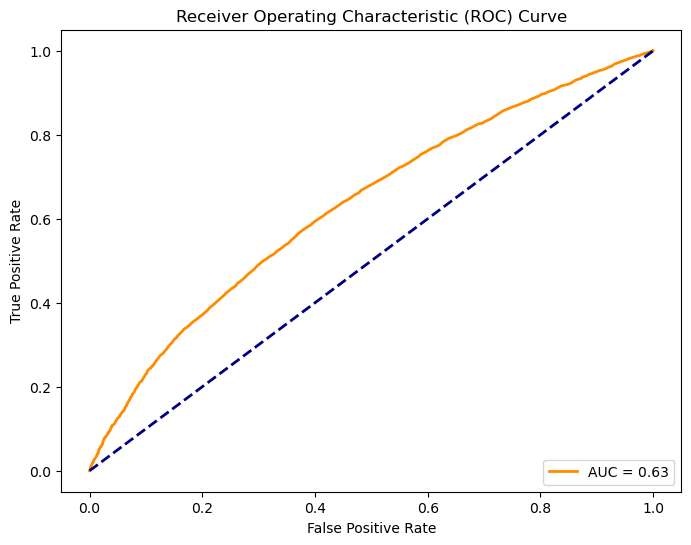

In [74]:
#visual plots of confusion matrix and roc-auc curve
knn_model_report.mod_viz()

C:\Users\rohan aryan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\rohan aryan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. 

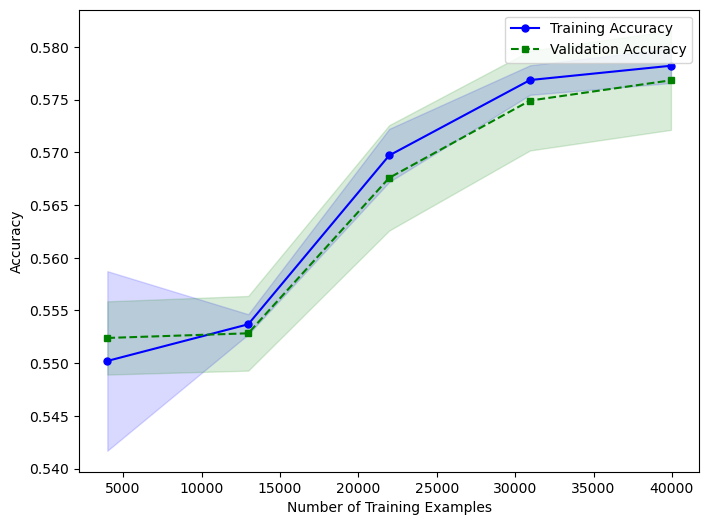

In [75]:
#learning curve plot for knn
knn_model_report.learning_curve(best_knn_classifier,X_train,y_train,5)

### Feature Importance

Since KNN does not have the attribute feature_importance_ we are implementing permutation_importance

In [ ]:
# Compute permutation importance
#result = permutation_importance(knn_model, X_test, y_test, n_repeats=10, random_state=42)

# Print the feature importances
print("KNN Permutation Importance:")
for feature, importance in zip(X.columns, result.importances_mean):
    print(f"{feature}: {importance}")

# Kaggle Score: